# **PRÁCTICA FINAL GRUPAL DE MÉTODOS ESTADÍSTICOS EN MINERÍA DE DATOS**
- Beatriz García Sanz
- Leire Pantoja Jiménez
- Yuxin Wang

# **Introducción**

En el entorno digital la información en la web desempeña un papel crucial en la toma de decisiones. Este trabajo se centra en la práctica del "web scraping" que es una técnica automatizada para extraer datos de sitios web. Una vez extraídos los datos se procederá a realizar distintos análisis para comprenderlos con más profundidad. Los datos elegidos son las 100 mayores empresas de Estados Unidos de ingresos en 2023 y se extraerá esta información de la Wikipedia.

# **Web Scraping**

Como ya se ha mencionado el Web Scraping es un proceso automatizado que permite la extracción de información directamente desde sitios web. La principal ventaja de este método es la automatización del proceso y la obtención de la información ya de forma estructurada. Para el proceso se utilizarán las librerías *BeautifulSoup* y *request*.

In [16]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.linear_model import Ridge
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score

El primer paso es crear un objeto BeautifulSoup e indicar cual es la URL de donde tiene que sacar los datos.

Se crea un objeto BeautifulSoup que analiza el contenido HTML de la página.

In [44]:
url = 'https://en.wikipedia.org/wiki/List_of_largest_companies_in_the_United_States_by_revenue'

pagina = requests.get(url)

soup = BeautifulSoup(pagina.text, 'html')

Se pide que se encuentre la primera tabla de la lista.

In [45]:
soup.find_all('table')[1]

<table class="wikitable sortable">
<caption>
</caption>
<tbody><tr>
<th>Rank
</th>
<th>Name
</th>
<th>Industry
</th>
<th>Revenue <br/>(USD millions)
</th>
<th>Revenue growth
</th>
<th>Employees
</th>
<th>Headquarters
</th></tr>
<tr>
<td>1
</td>
<td><a href="/wiki/Walmart" title="Walmart">Walmart</a>
</td>
<td><a href="/wiki/Retail" title="Retail">Retail</a>
</td>
<td style="text-align:center;">611,289
</td>
<td style="text-align:center;"><span typeof="mw:File"><span title="Increase"><img alt="Increase" class="mw-file-element" data-file-height="300" data-file-width="300" decoding="async" height="11" src="//upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Increase2.svg/11px-Increase2.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Increase2.svg/17px-Increase2.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Increase2.svg/22px-Increase2.svg.png 2x" width="11"/></span></span> <span data-sort-value="7000300000000000000♠" style="display:none"></span> 6.

Se asigna la tabla encontrada a una variable y se encuentran los nombres de las variables.

In [46]:
tabla = soup.find_all('table')[1]

In [47]:
nombres_variables = tabla.find_all('th')

In [ ]:
nombres_variables

[<th>Rank
 </th>,
 <th>Name
 </th>,
 <th>Industry
 </th>,
 <th>Revenue <br/>(USD millions)
 </th>,
 <th>Revenue growth
 </th>,
 <th>Employees
 </th>,
 <th>Headquarters
 </th>]

Se insertan en una lista los nombres de las variables.

In [48]:
nombres_variables2 = [title.text.strip() for title in nombres_variables]

print(nombres_variables2)

['Rank', 'Name', 'Industry', 'Revenue (USD millions)', 'Revenue growth', 'Employees', 'Headquarters']


Se crea un dataframe en blanco con los nombres de las variables.

In [49]:
df = pd.DataFrame(columns = nombres_variables2)

df

,Rank,Name,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters


Se introducen en una variable todas las filas de la tabla menos la del encabezado.

In [50]:
datos_tabla = tabla.find_all('tr')

Se añade al dataframe anterior.

In [51]:
for row in datos_tabla[1:]:
    row_data = row.find_all('td')
    individual_row_data = [data.text.strip() for data in row_data]

    length = len(df)
    df.loc[length] = individual_row_data

In [52]:
df

,Rank,Name,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters
0,1,Walmart,Retail,"611,289",6.7%,"2,100,000","Bentonville, Arkansas"
1,2,Amazon,Retail and cloud computing,"513,983",9.4%,"1,540,000","Seattle, Washington"
2,3,ExxonMobil,Petroleum industry,"413,680",44.8%,"62,000","Spring, Texas"
3,4,Apple,Electronics industry,"394,328",7.8%,"164,000","Cupertino, California"
4,5,UnitedHealth Group,Healthcare,"324,162",12.7%,"400,000","Minnetonka, Minnesota"
...,...,...,...,...,...,...,...
95,96,Best Buy,Retail,"46,298",10.6%,"71,100","Richfield, Minnesota"
96,97,Bristol-Myers Squibb,Pharmaceutical industry,"46,159",0.5%,"34,300","New York City, New York"
97,98,United Airlines,Airline,"44,955",82.5%,"92,795","Chicago, Illinois"
98,99,Thermo Fisher Scientific,Laboratory instruments,"44,915",14.5%,"130,000","Waltham, Massachusetts"


In [53]:
df.to_csv('/content/drive/MyDrive/Mineria de datos/datos_csv', index = False)

# **Análisis exploratorio de datos**

Una vez se tienen los datos de una forma estructurada se puede proceder a analizarlos. La base de datos cuenta con 100 instancias y 7 variables.
- **Rank:** posición que ocupan en el ranking de mayores ingresos.
- **Name:** nombre de la compañía.
- **Industry:** industria a la que se dedican.
- **Revenue (USD millions):** ingresos en el último año en millones de dólares.
- **Revenue Growth:** crecimiento de ingresos de manera porcentual en el último año.
- **Employees:** número de empleados.
- **Headquarters:** lugar donde se encuentra la sede principal de la empresa.

## **Transformaciones necesarias**

Lo primero que hay que hacer es añadir un *menos* en la columna Revenue Growth en algunas filas ya que en la Wikipedia estaba representado con una foto y el análisis de la página no lo ha detectado.

In [10]:
filas_con_guion   = [26,29,30,33,54,61,63,64,66,68,85,95,96]
columna_deseada  = 'Revenue growth'

In [11]:
df.loc[filas_con_guion, columna_deseada] = df.loc[filas_con_guion, columna_deseada].astype(str).apply(lambda x: '-' + x if not x.startswith('-') else x)

df

,Rank,Name,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters
0,1,Walmart,Retail,"611,289",6.7%,"2,100,000","Bentonville, Arkansas"
1,2,Amazon,Retail and cloud computing,"513,983",9.4%,"1,540,000","Seattle, Washington"
2,3,ExxonMobil,Petroleum industry,"413,680",44.8%,"62,000","Spring, Texas"
3,4,Apple,Electronics industry,"394,328",7.8%,"164,000","Cupertino, California"
4,5,UnitedHealth Group,Healthcare,"324,162",12.7%,"400,000","Minnetonka, Minnesota"
...,...,...,...,...,...,...,...
95,96,Best Buy,Retail,"46,298",-10.6%,"71,100","Richfield, Minnesota"
96,97,Bristol-Myers Squibb,Pharmaceutical industry,"46,159",-0.5%,"34,300","New York City, New York"
97,98,United Airlines,Airline,"44,955",82.5%,"92,795","Chicago, Illinois"
98,99,Thermo Fisher Scientific,Laboratory instruments,"44,915",14.5%,"130,000","Waltham, Massachusetts"


Se comprueba si hay datos faltantes y la respuesta es negativa.

In [ ]:
print(df.isnull().sum())

Rank                      0
Name                      0
Industry                  0
Revenue (USD millions)    0
Revenue growth            0
Employees                 0
Headquarters              0
dtype: int64


Como se puede comprobar todos los datos tienen formato *object* por lo que se procede a asignar a cada uno el formato más apropiado. La posición en el ranking, los ingresos y el número de empleados serán números enteros, el crecimiento un número decimal y la sede una cadena de texto.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Rank                    100 non-null    object
 1   Name                    100 non-null    object
 2   Industry                100 non-null    object
 3   Revenue (USD millions)  100 non-null    object
 4   Revenue growth          100 non-null    object
 5   Employees               100 non-null    object
 6   Headquarters            100 non-null    object
dtypes: object(7)
memory usage: 10.3+ KB


In [12]:
df['Rank']=df['Rank'].astype(int)
df['Revenue (USD millions)']=df['Revenue (USD millions)'].str.replace(',', '', regex=True).astype('int')
df['Revenue growth']=df['Revenue growth'].str[:-1].astype('float')
df['Employees']=df['Employees'].str.replace(',', '', regex=True).astype('int')
df['Headquarters']=df['Headquarters'].astype(str)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rank                    100 non-null    int64  
 1   Name                    100 non-null    object 
 2   Industry                100 non-null    object 
 3   Revenue (USD millions)  100 non-null    int64  
 4   Revenue growth          100 non-null    float64
 5   Employees               100 non-null    int64  
 6   Headquarters            100 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 10.3+ KB


Además es notable que algunas industrias son muy parecidas entre sí, como *Financial*, *Finalcials* y *Financial Services* por lo que se agrupan todas en bajo un nombre común para sintetizar el análisis.

In [ ]:
df['Industry'].unique()

array(['Retail', 'Retail and cloud computing', 'Petroleum industry',
       'Electronics industry', 'Healthcare', 'Conglomerate',
       'Technology and Cloud Computing', 'Health',
       'Pharmaceutical industry', 'Health Insurance',
       'Automotive industry', 'Financial services', 'Telecommunications',
       'Financials', 'Conglomerate and Telecomunications', 'Technology',
       'Food industry', 'Transportation', 'Beverage', 'Media',
       'Automotive and Energy', 'Consumer products Manufacturing',
       'Logistics', 'Food Service', 'Aerospace and defense',
       'Aerospace and Defense', 'Infotech', 'Machinery',
       'Petroleum industry and Logistics', 'Insurance',
       'Chemical industry', 'Financial', 'Food Processing',
       'Agriculture manufacturing', 'Telecom Hardware Manufacturing',
       'Airline', 'Agriculture cooperative', 'Apparel',
       'Laboratory instruments'], dtype=object)

In [13]:
df['Industry'] = df['Industry'].replace({'Aerospace and defense': 'Aerospace and Defense'})
df['Industry'] = df['Industry'].replace({'Financials': 'Financial'})
df['Industry'] = df['Industry'].replace({'Financial services': 'Financial'})
df['Industry'] = df['Industry'].replace({'Food Processing': 'Food industry'})
df['Industry'] = df['Industry'].replace({'Food Service': 'Food industry'})
df['Industry'] = df['Industry'].replace({'Health Insurance': 'Health'})
df['Industry'] = df['Industry'].replace({'Healthcare': 'Health'})
df['Industry'] = df['Industry'].replace({'Petroleum industry and Logistics': 'Petroleum industry'})
df['Industry'] = df['Industry'].replace({'Agriculture cooperative': 'Agriculture'})
df['Industry'] = df['Industry'].replace({'Agriculture manufacturing': 'Agriculture'})
df['Industry'] = df['Industry'].replace({'Retail and cloud computing': 'Retail'})
df['Industry'] = df['Industry'].replace({'Telecom Hardware Manufacturing': 'Telecommunications'})
df['Industry'] = df['Industry'].replace({'Technology and Cloud Computing': 'Technology'})
df['Industry'] = df['Industry'].replace({'Automotive and Energy': 'Automotive industry'})
df['Industry'] = df['Industry'].replace({'Conglomerate and Telecomunications': 'Conglomerate'})

In [14]:
df2 = df.copy()

## **Visualización y análisis**

Tras estas transformaciones ya se tienen los datos listos el análisis. Lo primero que se va a mirar es que industrias están más representadas en las 100 empresas con más ingresos de Estados Unidos.

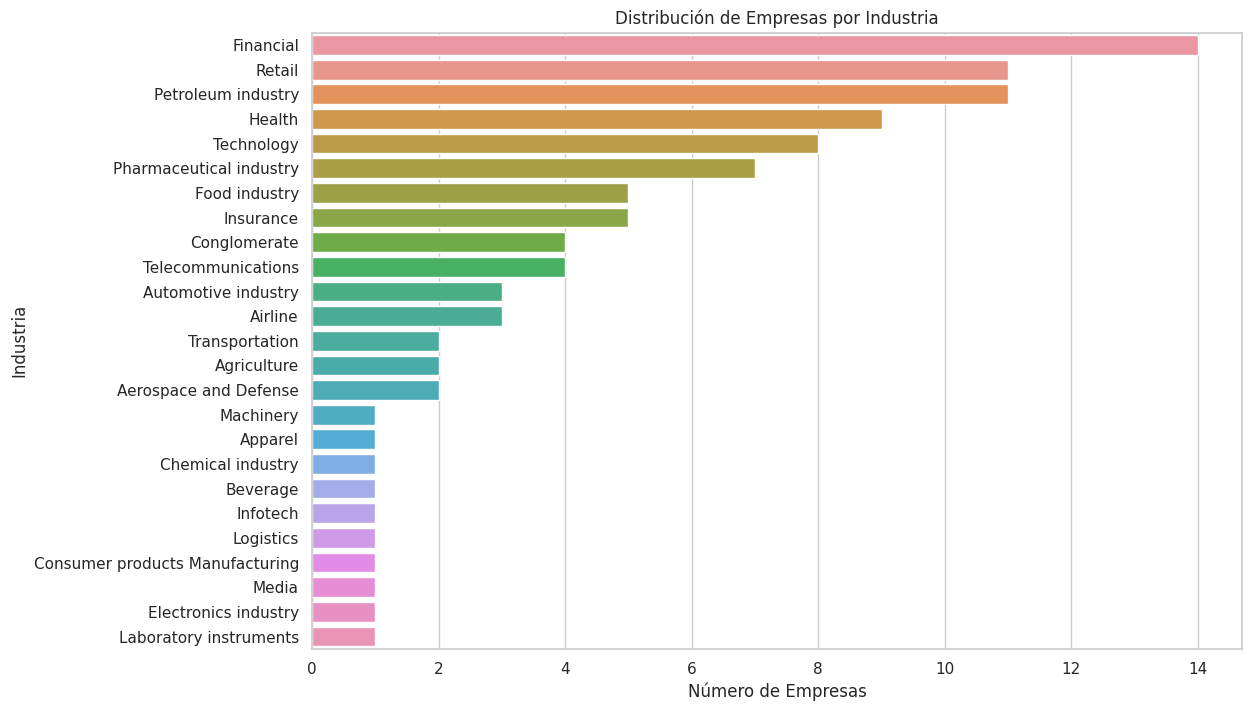

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.countplot(data=df, y='Industry', order=df['Industry'].value_counts().index)
plt.title('Distribución de Empresas por Industria')
plt.xlabel('Número de Empresas')
plt.ylabel('Industria')
plt.show()

Se ve en el gráfico que la industria más importante es la **financiera** con 14 empresas en el top 100, seguida del **retail** y la **industria petrolífera** ambas con una representación de 11 compañías. Por detrás se encuentran sectores tan importantes como la **salud**, la **tecnología** y la **industria farmacéutica**. Las industrias menos representadas son por ejemplo la logística, los medios de comunicación o la industria química.

Se hace un gráfico para ver cuáles son las industrias que generan más ingresos:

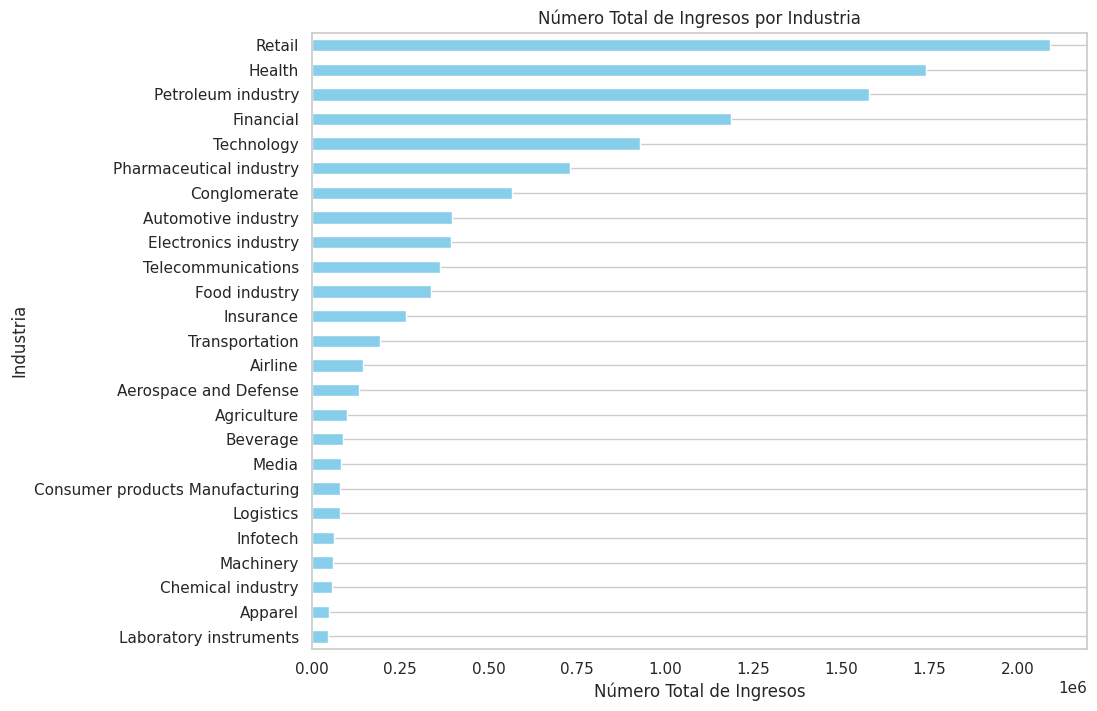

In [ ]:
total_ingresos_por_industria = df.groupby('Industry')['Revenue (USD millions)'].sum()

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 8))
total_ingresos_por_industria.sort_values().plot(kind='barh', color='skyblue')
plt.title('Número Total de Ingresos por Industria')
plt.xlabel('Número Total de Ingresos')
plt.ylabel('Industria')
plt.grid(axis='x')
plt.show()

En el acumulado por industria se observa que las compañías que se dedican al **retail**, a la **salud** y al **petróleo** son las que más ingresos generan.

Se comprueba cuáles son las industrias con mayor número de trabajadores para ver si coincide con las empresas con mayores ingresos.

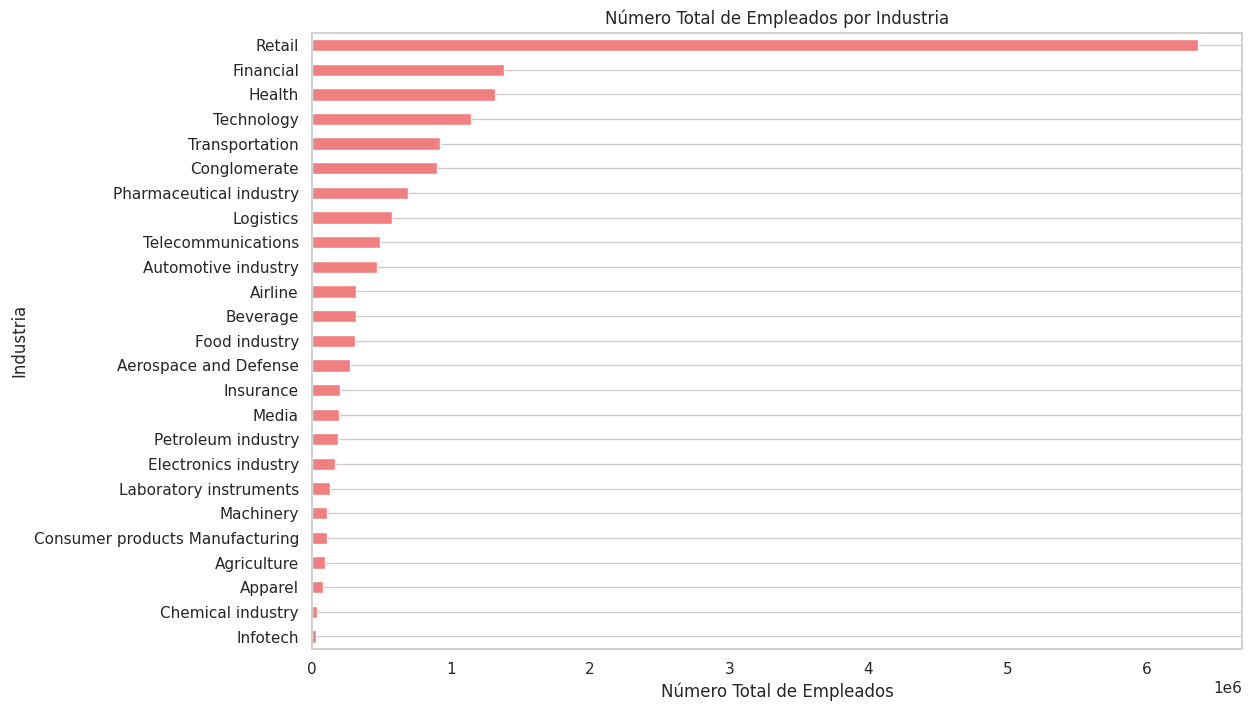

In [ ]:
total_empleados_por_industria = df.groupby('Industry')['Employees'].sum()

plt.figure(figsize=(12,8))

# El eje x está en millones de empleados.
total_empleados_por_industria.sort_values().plot(kind='barh', color='lightcoral')
plt.title('Número Total de Empleados por Industria')
plt.xlabel('Número Total de Empleados')
plt.ylabel('Industria')
plt.grid(axis='x')
plt.show()

Se ve muy claramente que la industria del **retail** es con mucha diferencia la que más empleos crea, seguida de la industria **financiera** y la **salud**. Por otra parte, tienen pocos trabajadores la industria **química** y la de la **infotecnología**.

Es interesante comprobar cuál es el ratio entre ingresos y trabajadores y como es la relación.

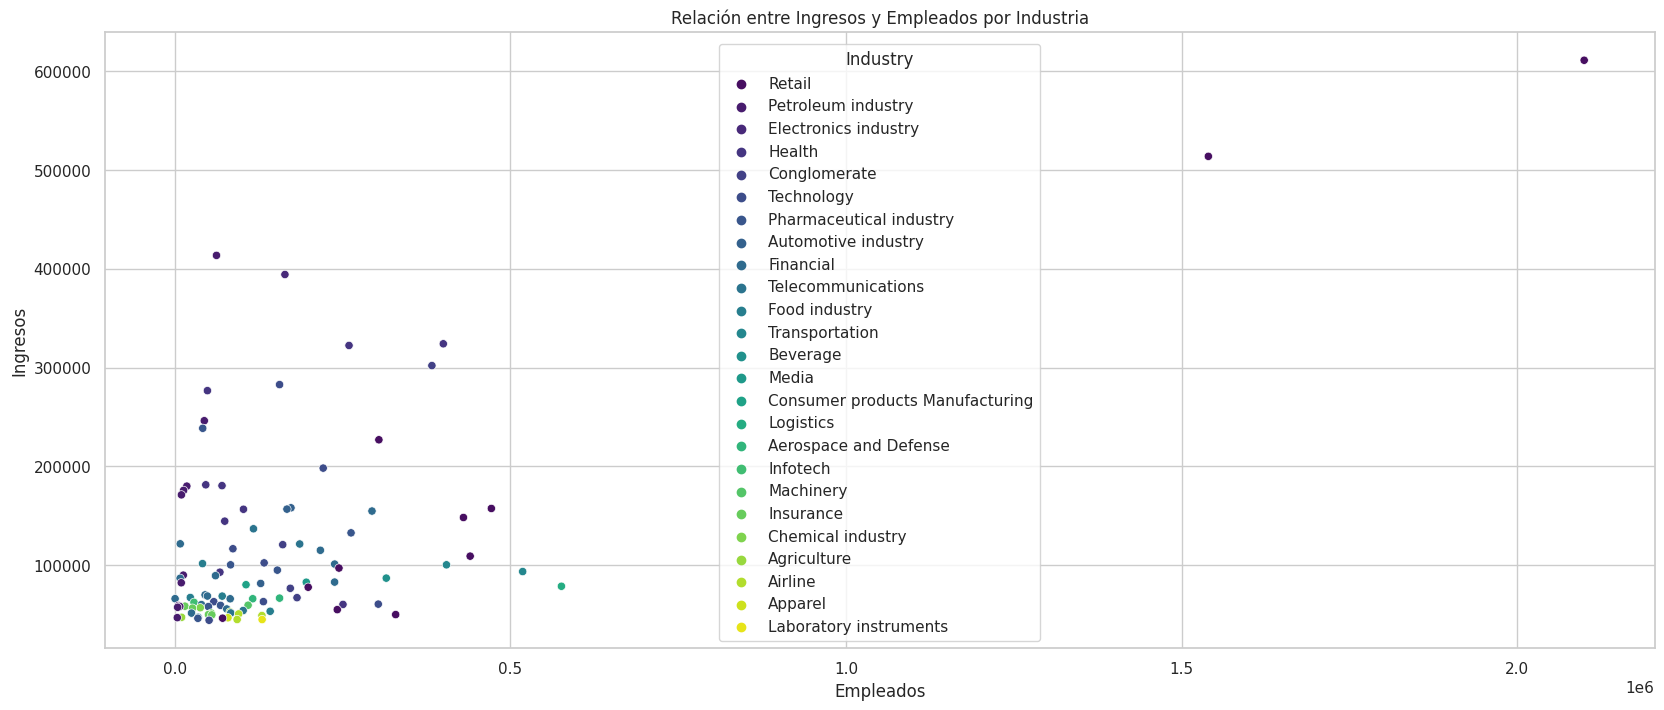

In [ ]:
plt.figure(figsize=(20, 8))
sns.scatterplot(data=df, x='Employees', y='Revenue (USD millions)', hue='Industry', palette='viridis')
plt.title('Relación entre Ingresos y Empleados por Industria')
plt.xlabel('Empleados')
plt.ylabel('Ingresos')
plt.show()

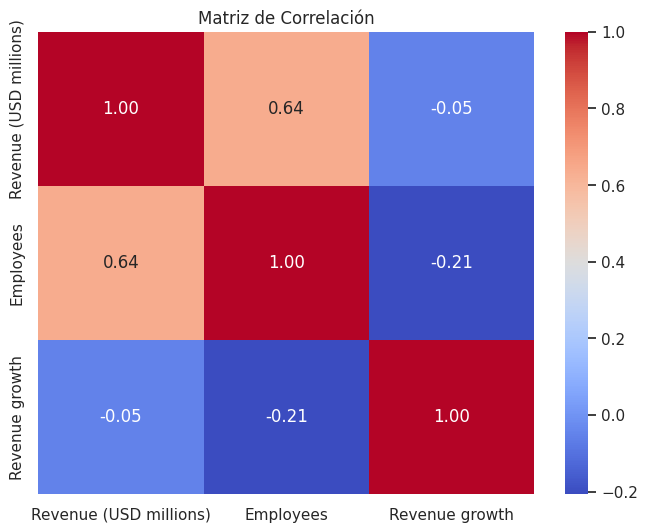

In [ ]:
correlation_matrix = df[['Revenue (USD millions)', 'Employees', 'Revenue growth']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Se ve que la correlación entre los ingresos y los empleados es de 0.64 la cual es este contexto es elevada.

<Figure size 1200x600 with 0 Axes>

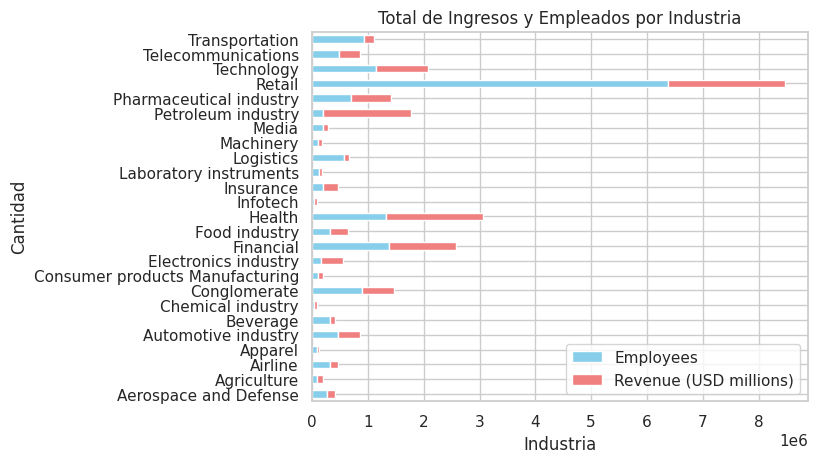

In [ ]:
# Total de ingresos y empleados por industria
industria_stats = df.groupby('Industry')[[ 'Employees','Revenue (USD millions)']].sum()
industria_stats_ordenado = industria_stats.sort_values(by='Revenue (USD millions)', ascending=False)
# Gráfico de barras apiladas para ingresos y empleados por industria
plt.figure(figsize=(12, 6))
industria_stats.plot(kind='barh', stacked=True, color=['skyblue', 'lightcoral'])
plt.title('Total de Ingresos y Empleados por Industria')
plt.xlabel('Industria')
plt.ylabel('Cantidad')
plt.show()

En el gráfico se ve que no en todos los casos un mayor número de empleados significa un mayor número de ingresos y que el ratio varía mucho según la industria. Un ejemplo claro es la industria petrolífera que con pocos empleados es de las empresas que más dinero genera.
Analíticamente se puede comprobar qué industrias tienen mayor y menor ratio.

In [ ]:
ratio_promedio_por_industria = df.groupby('Industry')['Ratio Ingresos/Empleados'].mean().reset_index()
ratio_promedio_por_industria = ratio_promedio_por_industria.sort_values(by='Ratio Ingresos/Empleados', ascending=False)

print(ratio_promedio_por_industria)

                           Industry  Ratio Ingresos/Empleados
10                        Financial                 18.156415
19               Petroleum industry                 10.501793
1                       Agriculture                  2.676061
9              Electronics industry                  2.404439
13                         Infotech                  2.187509
12                           Health                  2.152294
14                        Insurance                  1.777053
20          Pharmaceutical industry                  1.637687
11                    Food industry                  1.618609
6                 Chemical industry                  1.505344
22                       Technology                  0.932259
4               Automotive industry                  0.829767
8   Consumer products Manufacturing                  0.756481
23               Telecommunications                  0.742871
3                           Apparel                  0.590518
7       

La industria con un mayor ratio es la **financiera** en la que cada empresa genera aproximadamente 18.15 millones de dólares por empleado, y la que peor ratio tiene es la industria **logística** con 0.1364 millones de dólares. Se puede comprobar tambíen por empresas.

In [ ]:
empresa_max_ratio = df.loc[df['Ratio Ingresos/Empleados'].idxmax()]

empresa_min_ratio = df.loc[df['Ratio Ingresos/Empleados'].idxmin()]

print("Empresa con el mayor ratio:")
print(empresa_max_ratio[['Name', 'Ratio Ingresos/Empleados']])

print("\nEmpresa con el menor ratio:")
print(empresa_min_ratio[['Name', 'Ratio Ingresos/Empleados']])

Empresa con el mayor ratio:
Name                        StoneX Group
Ratio Ingresos/Empleados      216.511475
Name: 60, dtype: object

Empresa con el menor ratio:
Name                        United States Postal Service
Ratio Ingresos/Empleados                        0.136493
Name: 51, dtype: object


La empresa que genera más con menos empleados es **StoneX Group** lo que implica que cada empleado genera 216.51 millones de dólares y la empresa con un menor ratio es **United States Postal Services** con un ratio de 0.1364 lo que significa que cada empleado genera 136.000 dólares al año.

Otro análisis que se puede hacer es ver qué industrias son las que han tenido más y menos **crecimiento** en el último año.

In [ ]:
crecimiento_promedio_por_industria = df.groupby('Industry')['Revenue growth'].mean().reset_index()


crecimiento_promedio_por_industria = crecimiento_promedio_por_industria.sort_values(by='Revenue growth', ascending=False)


print(crecimiento_promedio_por_industria)

                           Industry  Revenue growth
13                         Infotech       97.200000
2                           Airline       71.866667
19               Petroleum industry       52.481818
4               Automotive industry       30.233333
11                    Food industry       28.280000
18                            Media       22.700000
1                       Agriculture       21.850000
17                        Machinery       16.600000
10                        Financial       15.650000
15           Laboratory instruments       14.500000
12                           Health        9.466667
5                          Beverage        8.700000
9              Electronics industry        7.800000
24                   Transportation        7.250000
20          Pharmaceutical industry        6.285714
21                           Retail        5.545455
14                        Insurance        5.360000
8   Consumer products Manufacturing        5.300000
3           

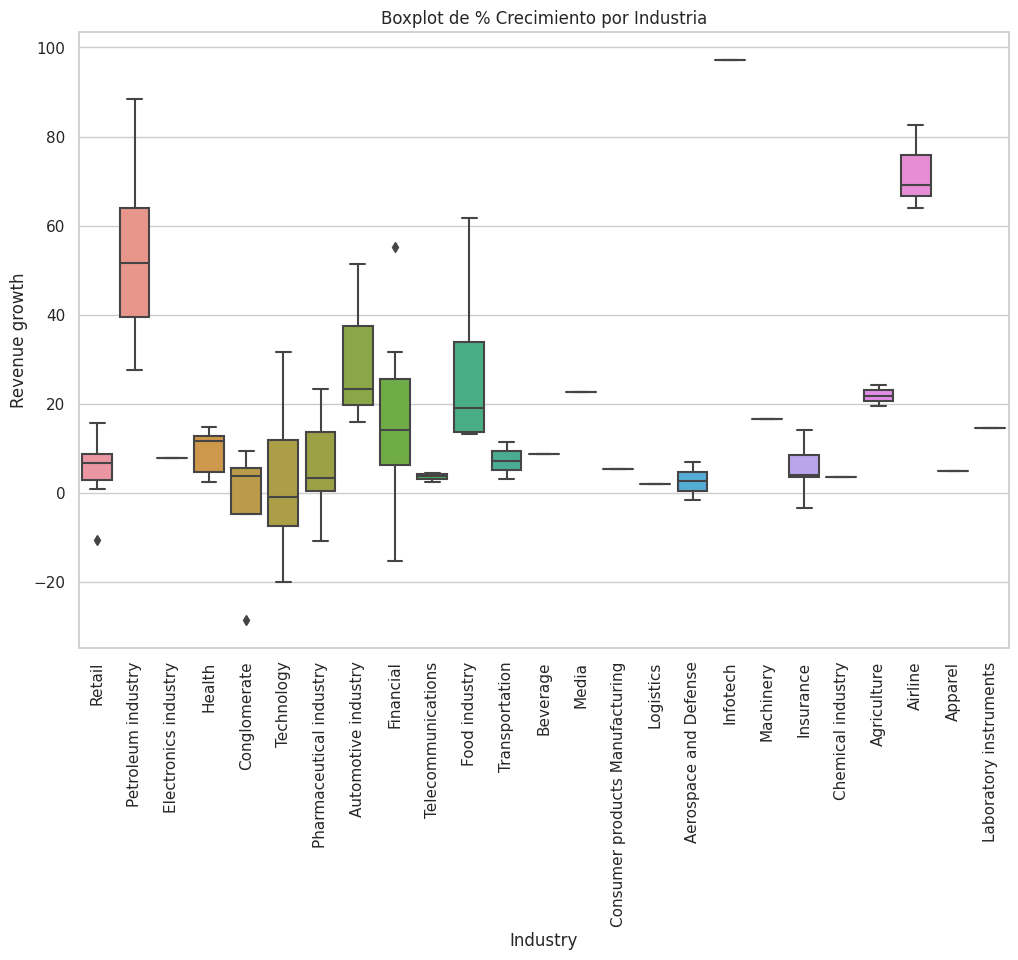

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Industry', y='Revenue growth', data=df)
plt.title('Boxplot de % Crecimiento por Industria')
plt.xticks(rotation=90)
plt.show()

La industria con un **mayor** crecimiento es la de la **infotecnología**, seguida de la industria **aeronáutica** y las que **menos** lo han hecho son la de **conglomerados** (que ha tenido menos ingresos) y la de **logística**.

In [ ]:
empresa_max_crecimiento = df.loc[df["Revenue growth"].idxmax()]

# Encontrar la empresa con menor Revenue growth
empresa_min_crecimiento = df.loc[df["Revenue growth"].idxmin()]

# Mostrar los resultados
print("Empresa con mayor Revenue growth:")
print(empresa_max_crecimiento)

print("\nEmpresa con menor Revenue growth:")
print(empresa_min_crecimiento)

Empresa con mayor Revenue growth:
Rank                                         66
Name                                  TD Synnex
Industry                               Infotech
Revenue (USD millions)                    62344
Revenue growth                             97.2
Employees                                 28500
Headquarters                Clearwater, Florida
Ratio Ingresos/Empleados               2.187509
Name: 65, dtype: object

Empresa con menor Revenue growth:
Rank                                   30
Name                                 AT&T
Industry                     Conglomerate
Revenue (USD millions)             120741
Revenue growth                      -28.5
Employees                          160700
Headquarters                Dallas, Texas
Ratio Ingresos/Empleados         0.751344
Name: 29, dtype: object


La empresa con mayor crecimiento de ingresos es **TD Synnex** con un 97.2% y la que menos es **AT&T** con un descenso del 28.5%.

Lo último que se va a ver en este primer análisis descriptivo es ver como están **geográficamente** distribuidas las empresas con el paquete *geopandas*.

In [ ]:
pip install geopandas

In [ ]:
import geopandas as gpd

In [ ]:
us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<ipython-input-31-a7ee508975ae>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  us_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Se separa la variable *Headquarters* en ciudad y estado y se añaden la latitud y longuitud de cada instancia.

In [ ]:
split_data = df['Headquarters'].str.split(', ', expand=True)
df['City'] = split_data[0]
df['State'] = split_data[1]

In [ ]:
merged = us_states.set_index('name').join(df.set_index('State'))

In [ ]:
df

,Rank,Name,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters,Ratio Ingresos/Empleados,City,State
0,1,Walmart,Retail,611289,6.7,2100000,"Bentonville, Arkansas",0.291090,Bentonville,Arkansas
1,2,Amazon,Retail,513983,9.4,1540000,"Seattle, Washington",0.333755,Seattle,Washington
2,3,ExxonMobil,Petroleum industry,413680,44.8,62000,"Spring, Texas",6.672258,Spring,Texas
3,4,Apple,Electronics industry,394328,7.8,164000,"Cupertino, California",2.404439,Cupertino,California
4,5,UnitedHealth Group,Health,324162,12.7,400000,"Minnetonka, Minnesota",0.810405,Minnetonka,Minnesota
...,...,...,...,...,...,...,...,...,...,...
95,96,Best Buy,Retail,46298,-10.6,71100,"Richfield, Minnesota",0.651167,Richfield,Minnesota
96,97,Bristol-Myers Squibb,Pharmaceutical industry,46159,-0.5,34300,"New York City, New York",1.345743,New York City,New York
97,98,United Airlines,Airline,44955,82.5,92795,"Chicago, Illinois",0.484455,Chicago,Illinois
98,99,Thermo Fisher Scientific,Laboratory instruments,44915,14.5,130000,"Waltham, Massachusetts",0.345500,Waltham,Massachusetts


In [ ]:
data3 = {
    'City': ['Bentonville', 'Seattle', 'Spring', 'Cupertino', 'Minnetonka',
       'Woonsocket', 'Omaha', 'Mountain View', 'Irving', 'San Ramon',
       'Chesterbrook', 'Issaquah', 'Redmond', 'Dublin', 'Bloomfield',
       'Findlay', 'Houston', 'San Antonio', 'Dearborn', 'Atlanta',
       'Detroit', 'Indianapolis', 'New York City', 'Cincinnati',
       'St. Louis', 'Deerfield', 'Washington', 'Philadelphia', 'Dallas',
       'Menlo Park', 'Charlotte', 'Minneapolis', 'Round Rock', 'Chicago',
       'Mooresville', 'New Brunswick', 'Memphis', 'Louisville',
       'Bloomington', 'McLean', 'Purchase', 'San Francisco', 'Burbank',
       'Austin', 'Boise', 'Boston', 'White Plains', 'Arlington County',
       'Bethesda', 'Santa Clara', 'Palo Alto', 'Clearwater', 'Armonk',
       'Nashville', 'Newark', 'Kenilworth', 'Miami', 'Lake Bluff',
       'Midland', 'Lakeland', 'Stamford', 'Springdale', 'Moline',
       'San Jose', 'Columbus', 'Northfield Township', 'Framingham',
       'Mayfield Village', 'Fort Worth', 'Inver Grove Heights',
       'Richmond', 'Parsippany–Troy Hills', 'Beaverton', 'Richfield',
       'Waltham', 'San Diego'],
    'Latitude': [ 36.658, 47.60621,30.085136,37.3194,42.0017,41.2647,37.3993,32.8577,37.7615,40.076,47.5404,47.6757,40.113,
                 41.8442,41.0459,29.7805,29.4595,42.3131,33.7629,42.383,39.7767,40.6643,39.1399,30.3212,42.1661,38.9040,
                  40.0094,32.7942,37.4797,35.2062,44.618,30.5237,41.8379,35.5853,40.4867,35.1035,38.2542,40.4758,38.9383,41.0384,
                  37.7272,34.1882,29.9471,43.5993,42.332,41.0253,38.8810,39.0265,37.3646,37.3998,27.9795,41.112,36.1718,40.7242,
                  52.3363,255.7751,42.2827,43.6248,28.056,41.0534,36.1866,41.4823,37.2969,39.9844,42.395,42.3079,42.3079,41.5173,32.7791,
                  44.8237,37.5314,40.8656,45.4798,44.8772,42.3889,32.8153],

    'Longitude': [-94.2291,-122.33207,-95.425186,-122.045,-71.4999,-96.0149,-122.079,-96.97,-121.938,-75.459,-122.042,-122.117,-83.1143,
                  -72.7414,-83.6376,-95.3863,-98.5221, -83.2115,-84.4227,-83.1022,-86.1459,-73.9385,-84.5064,-89.3544,-87.8525,-77.0171,
                  -75.1333,-96.7655,-122.148,-80.9326,-93.267,-97.6674,-87.6828,-80.8245,-74.444,-89.9785,-85.7603,-88.9714,-77.1832,
                  -73.7156,-123.032,-118.325,-96.2601,-116.232,-71.0202,-73.7521,-77.1048,-77.0737,-121.968,-122.143,-82.7646,
                  -73.7103,-86.785,-74.1726,-1.5827,-80.2105,-87.8523,-84.232,-81.9537,-73.5387,-94.153,-90.4935,-121.819,-82.9848,-83.7291,
                  -71.4362,-71.4362,-81.4539,-97.247,-93.0581,-77.476,-74.4247,-122.815,-93.2814,-71.2423,-117.135]
}

In [ ]:
df['State'] = df['State'].replace({'Cook County': 'Illinois'})

In [ ]:
df_lat_lon = pd.DataFrame(data3)

In [ ]:
df_completo = pd.merge(df, df_lat_lon, on='City', how='left')

In [ ]:
df_completo

,Rank,Name,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters,Ratio Ingresos/Empleados,City,State,Latitude,Longitude
0,1,Walmart,Retail,611289,6.7,2100000,"Bentonville, Arkansas",0.291090,Bentonville,Arkansas,36.658000,-94.229100
1,2,Amazon,Retail,513983,9.4,1540000,"Seattle, Washington",0.333755,Seattle,Washington,47.606210,-122.332070
2,3,ExxonMobil,Petroleum industry,413680,44.8,62000,"Spring, Texas",6.672258,Spring,Texas,30.085136,-95.425186
3,4,Apple,Electronics industry,394328,7.8,164000,"Cupertino, California",2.404439,Cupertino,California,37.319400,-122.045000
4,5,UnitedHealth Group,Health,324162,12.7,400000,"Minnetonka, Minnesota",0.810405,Minnetonka,Minnesota,42.001700,-71.499900
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Best Buy,Retail,46298,-10.6,71100,"Richfield, Minnesota",0.651167,Richfield,Minnesota,44.877200,-93.281400
96,97,Bristol-Myers Squibb,Pharmaceutical industry,46159,-0.5,34300,"New York City, New York",1.345743,New York City,New York,39.139900,-84.506400
97,98,United Airlines,Airline,44955,82.5,92795,"Chicago, Illinois",0.484455,Chicago,Illinois,35.585300,-80.824500
98,99,Thermo Fisher Scientific,Laboratory instruments,44915,14.5,130000,"Waltham, Massachusetts",0.345500,Waltham,Massachusetts,42.388900,-71.242300


In [ ]:
geometry = gpd.points_from_xy(df_completo['Longitude'], df_completo['Latitude'])

In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=geometry)

Además se añade la **región** para tener un análisis más completo.

In [ ]:
state_to_region = {
    'Connecticut': 'Nueva Inglaterra',
    'Maine': 'Nueva Inglaterra',
    'Massachusetts': 'Nueva Inglaterra',
    'New Hampshire': 'Nueva Inglaterra',
    'Rhode Island': 'Nueva Inglaterra',
    'Vermont': 'Nueva Inglaterra',
    'New York': 'Atlántico',
    'New Jersey': 'Atlántico',
    'Pennsylvania': 'Atlántico',
    'Delaware': 'Atlántico',
    'Maryland': 'Atlántico',
    'West Virginia': 'Atlántico',
    'Virginia': 'Atlántico',
    'North Carolina': 'Sur',
    'South Carolina': 'Sur',
    'Georgia': 'Sur',
    'Florida': 'Sur',
    'Arkansas': 'Sur',
    'Alabama': 'Sur',
    'Tennessee': 'Sur',
    'Mississippi': 'Sur',
    'Kentucky': 'Sur',
    'D.C.' : 'Sur',
    'Ohio': 'Oeste Medio',
    'Michigan': 'Oeste Medio',
    'Indiana': 'Oeste Medio',
    'Illinois': 'Oeste Medio',
    'Wisconsin': 'Oeste Medio',
    'Minnesota': 'Oeste',
    'Iowa': 'Oeste Medio',
    'Missouri': 'Oeste Medio',
    'North Dakota': 'Oeste',
    'South Dakota': 'Oeste',
    'Nebraska': 'Oeste',
    'Kansas': 'Oeste',
    'Montana': 'Oeste',
    'Idaho': 'Oeste',
    'Wyoming': 'Oeste',
    'Colorado': 'Oeste',
    'New Mexico': 'Suroeste',
    'Arizona': 'Suroeste',
    'Oklahoma': 'Suroeste',
    'Texas': 'Suroeste',
    'California': 'Oeste',
    'Oregon': 'Oeste',
    'Washington': 'Oeste',
    'Alaska': 'Oeste',
    'Hawaii': 'Oeste'
}


df_completo['Region'] = df_completo['State'].map(state_to_region)


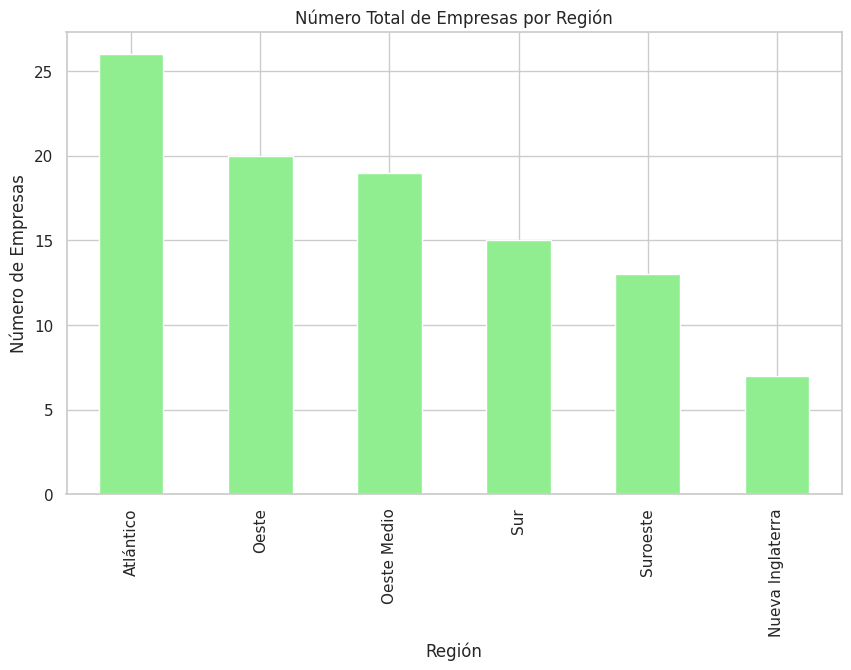

In [ ]:
companies_by_region = df_completo['Region'].value_counts()

plt.figure(figsize=(10, 6))
companies_by_region.plot(kind='bar', color='lightgreen')
plt.title('Número Total de Empresas por Región')
plt.xlabel('Región')
plt.ylabel('Número de Empresas')
plt.show()

Como se puede ver la zona donde más empresas se sitúan es la zona del **Atlántico**, seguido la zona **OESTE** y donde menos hay es en  **Nueva Inglaterra.** Se hace un mapa para verlo gráficamente.

In [ ]:
url = "https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_20m.zip"
gdf_us_states = gpd.read_file(url)

In [ ]:
us_states['boundary'] = us_states.boundary
us_states_boundaries = us_states[['geometry', 'boundary']].unary_union

In [ ]:
empresas_geo = gpd.GeoDataFrame(df_completo, geometry=gpd.points_from_xy(df_completo['Longitude'], df_completo['Latitude']))
empresas_geo.crs = gdf_us_states.crs

empresas_con_estados = gpd.sjoin(empresas_geo, gdf_us_states, how="inner", op="within")


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


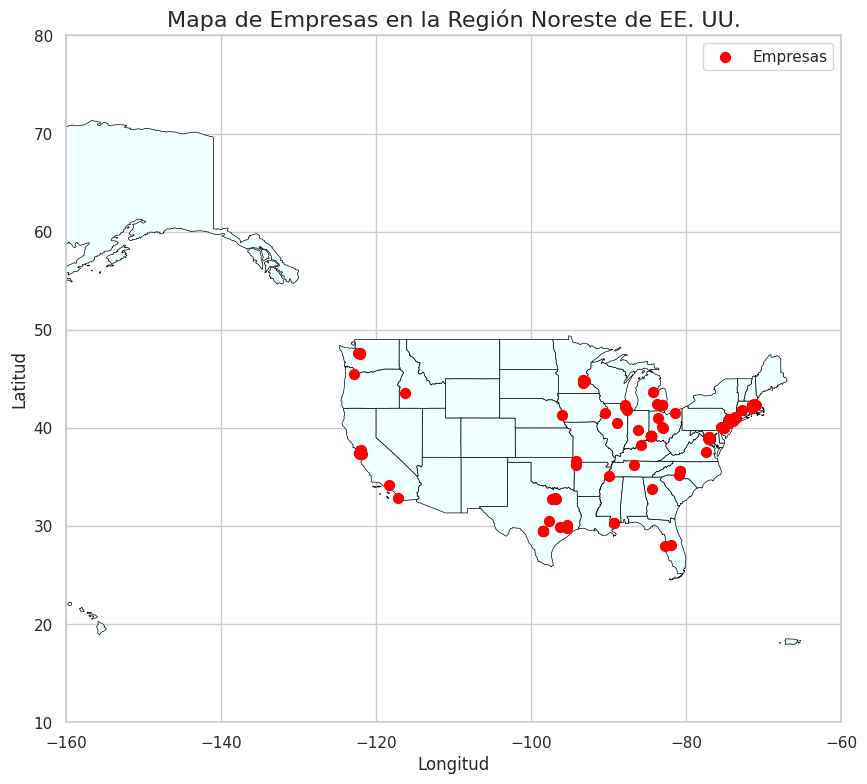

In [ ]:
xmin, ymin, xmax, ymax = [-160, 10, -60,80]

gdf_northeast = gdf_us_states.cx[xmin:xmax, ymin:ymax]

fig, ax = plt.subplots(figsize=(10, 15))

gdf_northeast.plot(ax=ax, edgecolor='black', linewidth=0.5, color='azure')

empresas_con_estados.plot(ax=ax, color='red', marker='o', markersize=50, label='Empresas')

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

plt.title('Mapa de Empresas en la Región Noreste de EE. UU.', fontsize=16)
plt.xlabel('Longitud')
plt.ylabel('Latitud')

ax.legend()

plt.show()


Para ver la distribución por regiones se hace el siguiente mapa.

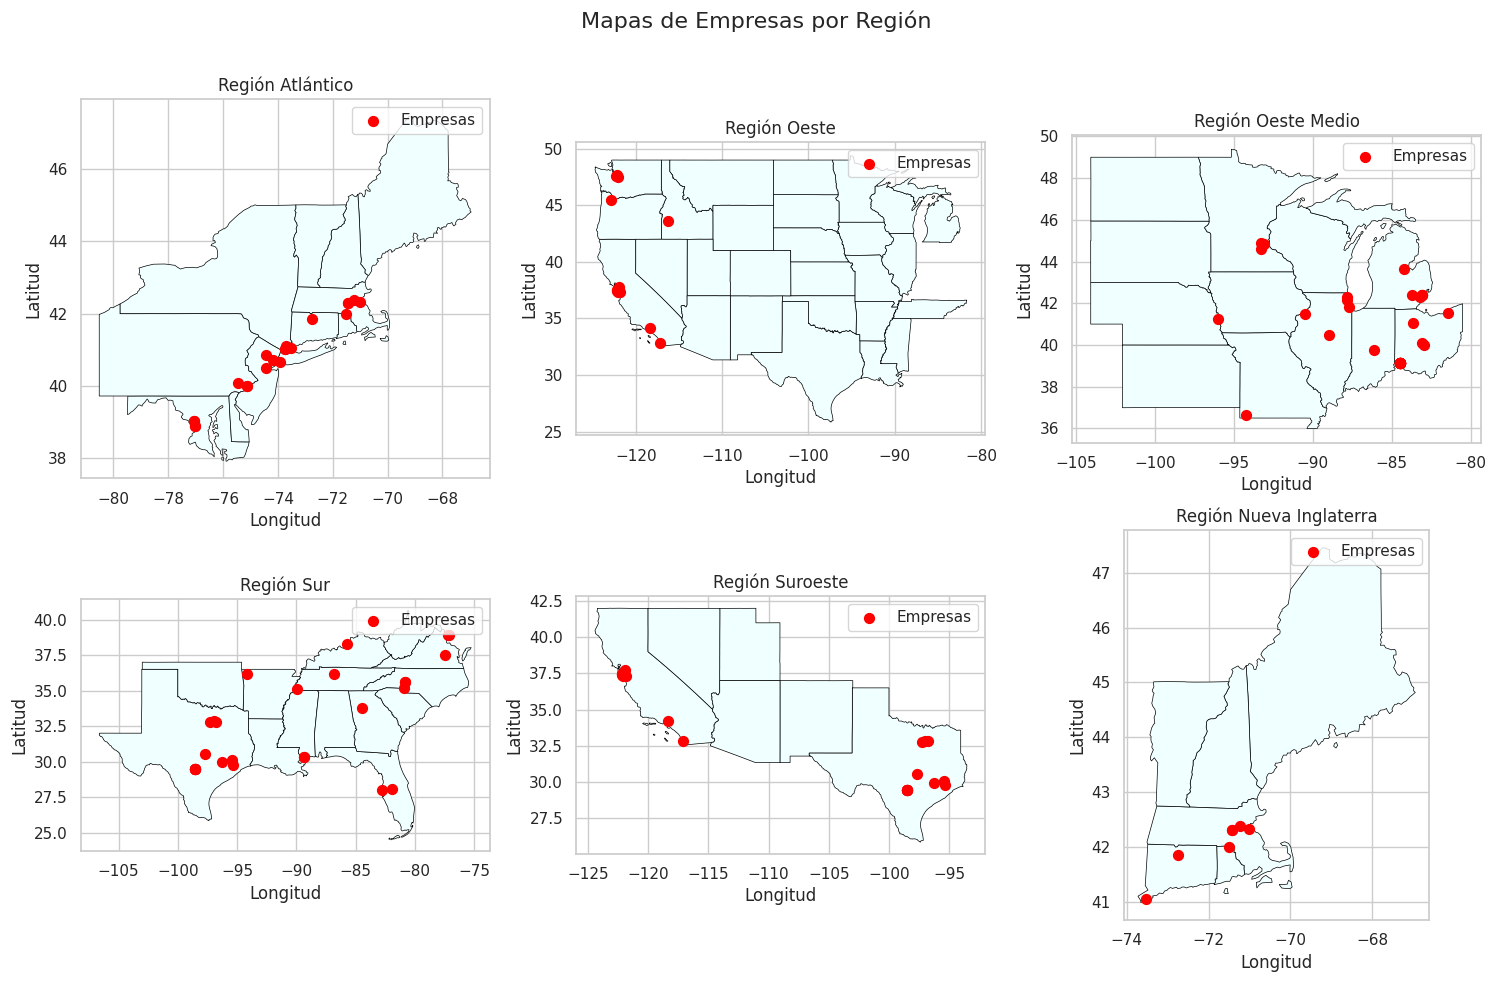

In [ ]:
regiones = {
    'Atlántico': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Maryland', 'District of Columbia'],
    'Oeste': ['Washington', 'Oregon', 'California', 'Nevada', 'Idaho', 'Utah', 'Arizona', 'Montana', 'Wyoming', 'Colorado', 'New Mexico', 'Alaska', 'Hawaii'],
    'Oeste Medio': ['North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Indiana', 'Michigan', 'Ohio'],
    'Sur': ['Texas', 'Oklahoma', 'Arkansas', 'Louisiana', 'Mississippi', 'Alabama', 'Tennessee', 'Kentucky', 'West Virginia', 'Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida'],
    'Suroeste': ['California', 'Nevada', 'Utah', 'Arizona', 'New Mexico', 'Texas'],
    'Nueva Inglaterra': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut']
}


# Crear un mapa por región
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Mapas de Empresas por Región', fontsize=16)

for i, (region, estados) in enumerate(regiones.items()):
    ax = axes[i // 3, i % 3]


    if region == 'Oeste':

        xmin, ymin, xmax, ymax = [-190, 30, -90, 50]
        gdf_region = gdf_us_states.cx[xmin:xmax, ymin:ymax]
    else:
        gdf_region = gdf_us_states[gdf_us_states['NAME'].isin(estados)]


    gdf_region.plot(ax=ax, edgecolor='black', linewidth=0.5, color='azure')


    empresas_region = empresas_con_estados[empresas_con_estados['NAME'].isin(estados)]


    empresas_region.plot(ax=ax, color='red', marker='o', markersize=50, label='Empresas')

    # Añadir títulos y etiquetas
    ax.set_title(f'Región {region}')
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')


    ax.legend()


plt.tight_layout(rect=[0, 0, 1, 0.96])


plt.show()

Por último si se quiere ver un mapa con las industrias se hace lo siguiente:

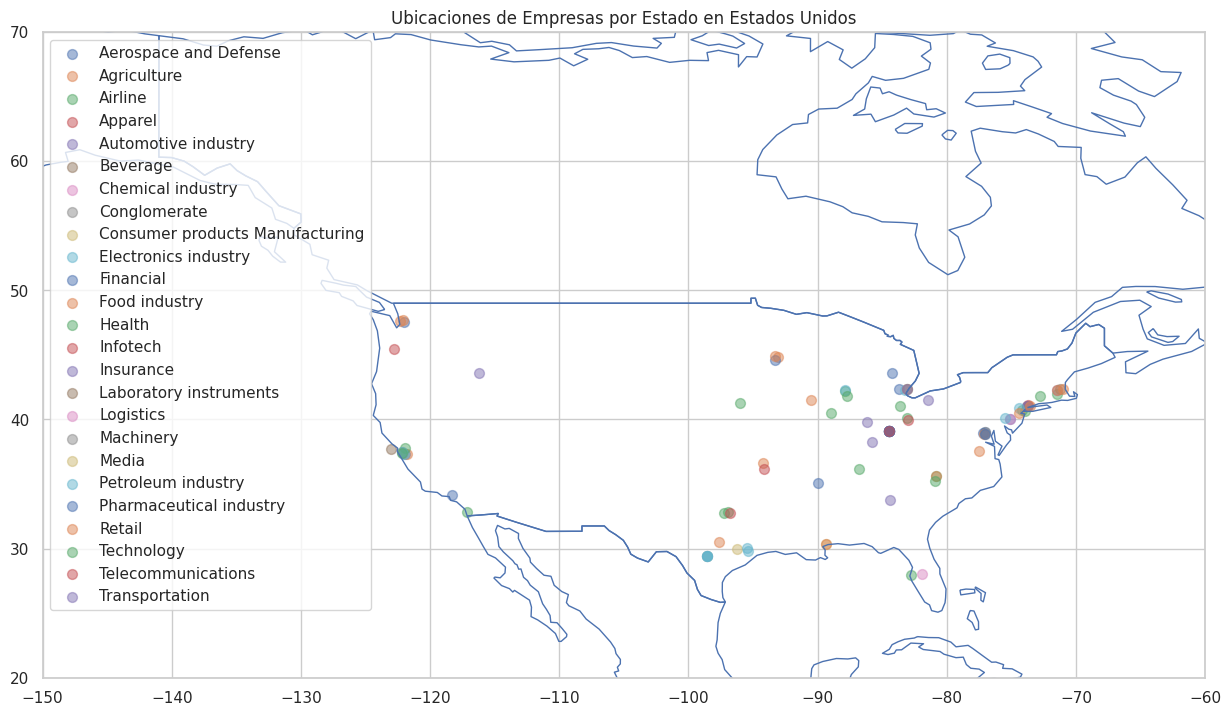

In [ ]:
xlim = [-150, -60]
ylim = [20, 70]

us_states = us_states.cx[xlim[0]:xlim[1], ylim[0]:ylim[1]]

fig, ax = plt.subplots(figsize=(15, 10))
us_states.boundary.plot(ax=ax, linewidth=1)

for estado, data_estado in gdf.groupby('Industry'):
    data_estado.plot(ax=ax, markersize=50, label=estado, alpha=0.5)

plt.title('Ubicaciones de Empresas por Estado en Estados Unidos')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend()
plt.show()

### **Conclusiones del análisis descriptivo**

Tras la realización de este análisis descriptivo se pueden resumir las principales conclusiones que se han alcanzado.

- Las **industrias** con **más** **empresas** en el top 100 son la **financiera**, el **retail** y las **petroleras**.

- Las **industrias** con **más ingresos** son la del **retail**, la de la **salud** y la del **petróleo**.

- Las **industrias** que generan **más trabajo** son la del **retail**, la **financiera** y la de la **salud**.

- La **industria** con un **mejor ratio** entre **ingresos y empleados** es la **financiera** con **StoneX Group** a la cabeza y la que **peor** lo tiene es la de la **logística** con **United States Postal Service**.

- La **industria** con un **mayor crecimiento** es la de la **infotecnología** con **TD Synnex** y la que **menos crece** es la de los **conglomerados** con **AT&T**.

# **Regresión**

Por último se van a ajustar distintos modelos para **predecir** la variable **ingresos**. Lo primero es realizar el preprocesado adecuado, que en este caso consiste en convertir las variables categórcias en dummys.

In [ ]:
categorical_data = df[['Industry', 'Headquarters']]

encoder = OneHotEncoder(sparse=False)
categorical_encoded = encoder.fit_transform(categorical_data)

categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_data.columns))

independent_variables = pd.concat([df[['Employees']], categorical_encoded_df], axis=1)

independent_variables.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Employees,Industry_Aerospace and Defense,Industry_Agriculture,Industry_Airline,Industry_Apparel,Industry_Automotive industry,Industry_Beverage,Industry_Chemical industry,Industry_Conglomerate,Industry_Consumer products Manufacturing,...,"Headquarters_Santa Clara, California","Headquarters_Seattle, Washington","Headquarters_Spring, Texas","Headquarters_Springdale, Arkansas","Headquarters_St. Louis, Missouri","Headquarters_Stamford, Connecticut","Headquarters_Waltham, Massachusetts","Headquarters_Washington, D.C.","Headquarters_White Plains, New York","Headquarters_Woonsocket, Rhode Island"
0,2100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1540000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,164000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las **variables independientes** que se van a utilizar son el número de **empleados**, la **industria** y la **sede**.

## **Lineal**

El primer modelo que se va a ajustar es un modelo de **regresión lineal**.

In [ ]:
# Variable dependiente
dependent_variable = df['Revenue (USD millions)']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(independent_variables, dependent_variable, test_size=0.15, random_state=42)

# Modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir con la muestra de test
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(" MSE (Linear):", mse)
print(" RMSE (Linear):", rmse)
print(" R-squared (Linear):", r2)

 MSE (Linear): 4879883648.860009
 RMSE (Linear): 69856.16400046606
 R-squared (Linear): 0.740514595157975


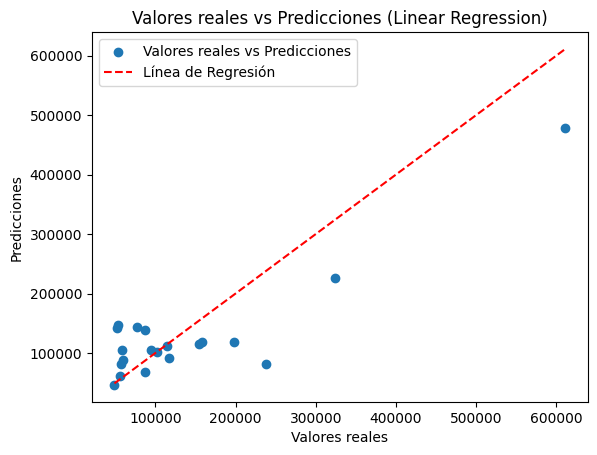

In [ ]:
# Graficar los valores reales vs predicciones con la línea de regresión
plt.scatter(y_test, y_pred, label='Valores reales vs Predicciones')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de Regresión')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones (Linear Regression)")
plt.legend()
plt.show()

Se obtiene un $R^2$ de **0.7405** lo que significa que el 74.05% de la variabilidad de los ingresos viene explicada por esos predictores. Además se obtiene un Error Cuadrático Medio de 69 856.

In [ ]:
coeficientes = model.coef_
intercepto = model.intercept_


ecuacion_recta = f"Ecuación de la recta: y = {intercepto:.2f} + {coeficientes[0]:.2f} * X1 + {coeficientes[1]:.2f} * X2 + ..."

print("Coeficientes:")
print(coeficientes)
print("\nIntercepto:")
print(intercepto)
print("\n" + ecuacion_recta)

Coeficientes:
[ 2.03800363e-01  6.74039680e+04 -2.25301623e+04 -5.42174269e+04
 -2.18453774e+04  9.84838400e+03 -3.43139254e-06 -1.25408999e+04
  6.25711586e+04 -2.61873260e+04  1.43312297e+05 -6.29627969e+03
  1.29025250e+04  8.02260217e+04 -8.87222817e+03 -7.57339631e+03
 -2.79295966e+04 -1.65030886e+05 -4.15324294e+04 -1.57311285e+04
  6.18961254e+04  4.80594899e+02 -2.41476436e+04  1.12131414e+04
  5.21589637e+04 -6.75783993e+04 -1.06868971e+05 -8.67351774e+04
  1.11582465e+04 -2.87234254e+04 -2.18453773e+04 -4.85204509e-07
 -9.93409561e+04  1.16967290e+04  9.01033954e+03 -1.29674445e+04
 -2.69407678e+04 -1.57311285e+04  2.88052761e+03  7.30171450e-07
  5.98062626e+03  1.04913416e+04 -8.87222817e+03 -2.15862811e+04
  1.43312297e+05 -4.88610229e+04  2.22399103e-06  4.44466384e+03
  3.85718094e+04  1.74758826e+04  4.02080822e+04  8.84756446e-07
 -6.72468218e+04 -3.29166346e+04 -1.87395648e+04 -6.59684054e+03
  1.12320515e+05  1.14866187e+05  2.58442014e-08 -2.68967590e+04
 -4.4510190

Al ver que el modelo lineal no ajusta mal los datos se procede a implementar un modelo de regresión con Ridge para observar si la penalización a los predictores tiene importancia y mejora el modelo.

## **Ridge**

La regresión Ridge es una técnica de regresión lineal que agrega un término de regularización que ayuda a prevenir el sobreajuste ya que los coeficientes no pueden tomar valores extremadamente grandes. El primer paso es encontrar el valor del parámetro que minimice el Error Cuadrático Medio.

In [ ]:
alpha_values = [0.1, 1, 10]
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)


    y_pred = ridge_model.predict(X_test)


    mse = mean_squared_error(y_test, y_pred)


    print(f"Alpha: {alpha}, MSE: {mse}")



Alpha: 0.1, MSE: 3483356729.505614
Alpha: 1, MSE: 3198147167.851212
Alpha: 10, MSE: 3038038171.009772


Como se observa se obtiene un MSE más bajo si alpha es igual a 10, por lo que e ajusta el modelo con este valor.

In [ ]:
ridge_model = Ridge(alpha=10)

ridge_model.fit(X_train, y_train)


y_pred_ridge = ridge_model.predict(X_test)


mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("MSE (Ridge):", mse_ridge)
print("RMSE (Ridge):", rmse_ridge)
print("R-squared (Ridge):", r2_ridge)

MSE (Ridge): 3038038171.009772
RMSE (Ridge): 55118.40138292993
R-squared (Ridge): 0.838453819505685


El valor obtenido de $R^2$ es de **0.8384** que es significativamente superior al obtenido con regresión lineal y el valor de RMSE  es 55 118 que también es mejor que el del modelo anterior.

### **Gradient Boosting**

Por último se va a ajustar un modelo más complejo como es el Gradient Boosting para ver si se mejoran las predicciones. El método Gradient Boosting utiliza un proceso secuencial para la construcción de los árboles, se crea uno inicial y los posteriores se centran en corregir los errores de los anteriores. Es un método muy potente a la hora de modelar relaciones complejas e incluye técnicas de regularización para evitar el sobreajuste que es una de sus principales desventajas.

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'eta': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 1,
    'objective': 'reg:squarederror',
}

modelB = xgb.train(params, dtrain, num_boost_round=999)

y_pred_xgb = modelB.predict(dtest)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("MSE (XGBoost):", mse_xgb)
print("RMSE (XGBoost):", rmse_xgb)
print("R-squared (XGBoost):", r2_xgb)

MSE (XGBoost): 3780560383.6121492
RMSE (XGBoost): 61486.26174693132
R-squared (XGBoost): 0.7989705672797155


Como se puede comprobar el $R^2$ obtenido es de **0.7989** que está muy por debajo del 0.8384 que se consigue con el modelo de regresión de Ridge así que en este caso un modelo más complejo no es mejor.

# **Clustering**


El último análisis que se va a realizar es hacer una **técnica de clustering** para intentar dividir las 100 empresas en distintos grupos.

In [17]:
df2['State'] = df2['Headquarters'].apply(lambda x: x.split(', ')[-1])
df2

,Rank,Name,Industry,Revenue (USD millions),Revenue growth,Employees,Headquarters,State
0,1,Walmart,Retail,611289,6.7,2100000,"Bentonville, Arkansas",Arkansas
1,2,Amazon,Retail,513983,9.4,1540000,"Seattle, Washington",Washington
2,3,ExxonMobil,Petroleum industry,413680,44.8,62000,"Spring, Texas",Texas
3,4,Apple,Electronics industry,394328,7.8,164000,"Cupertino, California",California
4,5,UnitedHealth Group,Health,324162,12.7,400000,"Minnetonka, Minnesota",Minnesota
...,...,...,...,...,...,...,...,...
95,96,Best Buy,Retail,46298,-10.6,71100,"Richfield, Minnesota",Minnesota
96,97,Bristol-Myers Squibb,Pharmaceutical industry,46159,-0.5,34300,"New York City, New York",New York
97,98,United Airlines,Airline,44955,82.5,92795,"Chicago, Illinois",Illinois
98,99,Thermo Fisher Scientific,Laboratory instruments,44915,14.5,130000,"Waltham, Massachusetts",Massachusetts


Para esta técnica se eliminan las variables **Headquarters** y **Rank** ya que no aportan mucha información adicional. Por lo que se va a trabajar con las siguientes variables:

In [18]:
df2 = df2.drop(columns=['Headquarters'])
df2 = df2.drop(columns=['Rank'])

In [ ]:
df2

,Name,Industry,Revenue (USD millions),Revenue growth,Employees,State
0,Walmart,Retail,611289,6.7,2100000,Arkansas
1,Amazon,Retail,513983,9.4,1540000,Washington
2,ExxonMobil,Petroleum industry,413680,44.8,62000,Texas
3,Apple,Electronics industry,394328,7.8,164000,California
4,UnitedHealth Group,Health,324162,12.7,400000,Minnesota
...,...,...,...,...,...,...
95,Best Buy,Retail,46298,-10.6,71100,Minnesota
96,Bristol-Myers Squibb,Pharmaceutical industry,46159,-0.5,34300,New York
97,United Airlines,Airline,44955,82.5,92795,Illinois
98,Thermo Fisher Scientific,Laboratory instruments,44915,14.5,130000,Massachusetts


Se agrupan las variables numéricas juntas bajo el nombre "numeric_features" y se hace lo mismo con las categóricas, ya que se preprocesan de maneras distintas.

In [19]:
numeric_features = df2[['Revenue (USD millions)', 'Revenue growth', 'Employees']]
categorical_features = df2[['Industry', 'State','Name']]

Se crea el **preprocesamiento** de datos, que implica **estandarizar** las **variables numéricas** para que todas estén en la misma "escala" (para que sean comparables) y se **codifican** las **variables categóricas** con números (se crea una columna adicional por cada categoría que tenga cada variable categórica y cada columna estará compuesta de 1s en las filas en las que pertenezcan a una categoría específica y 0s en el resto).

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features.columns),
        ('cat', OneHotEncoder(), categorical_features.columns)
    ])

Se crea una **pipeline** que contenga el **preprocesamiento** de datos y el **modelo** que se va a llevar a cabo, que en este caso es el **K-Means** Clustering.

In [21]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters = 3, random_state=42))
])

Se ajusta la pipa a los datos y se obtiene una tabla que proporciona una visual de qué se le ha aplicado a cada tipo de variables.

In [22]:
pipeline.fit(df2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Revenue (USD millions)', 'Revenue growth', 'Employees'], dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['Industry', 'State', 'Name'], dtype='object'))])),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

Se añade una columna a la tabla de datos original que diga a qué cluster pertenece cada instancia.

In [23]:
transformed_features = pipeline.named_steps['preprocessor'].transform(df2)

In [24]:
df2['Cluster'] = pipeline.named_steps['kmeans'].labels_
df2

,Name,Industry,Revenue (USD millions),Revenue growth,Employees,State,Cluster
0,Walmart,Retail,611289,6.7,2100000,Arkansas,0
1,Amazon,Retail,513983,9.4,1540000,Washington,0
2,ExxonMobil,Petroleum industry,413680,44.8,62000,Texas,1
3,Apple,Electronics industry,394328,7.8,164000,California,2
4,UnitedHealth Group,Health,324162,12.7,400000,Minnesota,2
...,...,...,...,...,...,...,...
95,Best Buy,Retail,46298,-10.6,71100,Minnesota,2
96,Bristol-Myers Squibb,Pharmaceutical industry,46159,-0.5,34300,New York,2
97,United Airlines,Airline,44955,82.5,92795,Illinois,1
98,Thermo Fisher Scientific,Laboratory instruments,44915,14.5,130000,Massachusetts,2


Una vez se tienen los clusters hechos se puede ver que características tiene cada uno.

In [ ]:
resultados = df2.groupby('Cluster').mean().round(2)
print(resultados)

         Revenue (USD millions)  Revenue growth   Employees
Cluster                                                    
0                     562636.00            8.05  1820000.00
1                     103913.11           59.14    41687.44
2                     109511.72            8.09   155157.91


<ipython-input-35-9025c0bf73e6>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultados = df2.groupby('Cluster').mean().round(2)


In [ ]:
conteo_clusters = df2['Cluster'].value_counts()
print(conteo_clusters)

2    80
1    18
0     2
Name: Cluster, dtype: int64


Lo primero que llama la atención es que los **clusters** están muy **desbalanceados** ya que en el 0 hay solo 2 empresas, en el 1 hay 18 y en el 2 hay 88 de ellas, lo que puede indicar que los resultados no sean muy fiables pero eso se comprobará mas adelante con la silueta. Se realizan más gráficos para ver la composición de cada cluster.

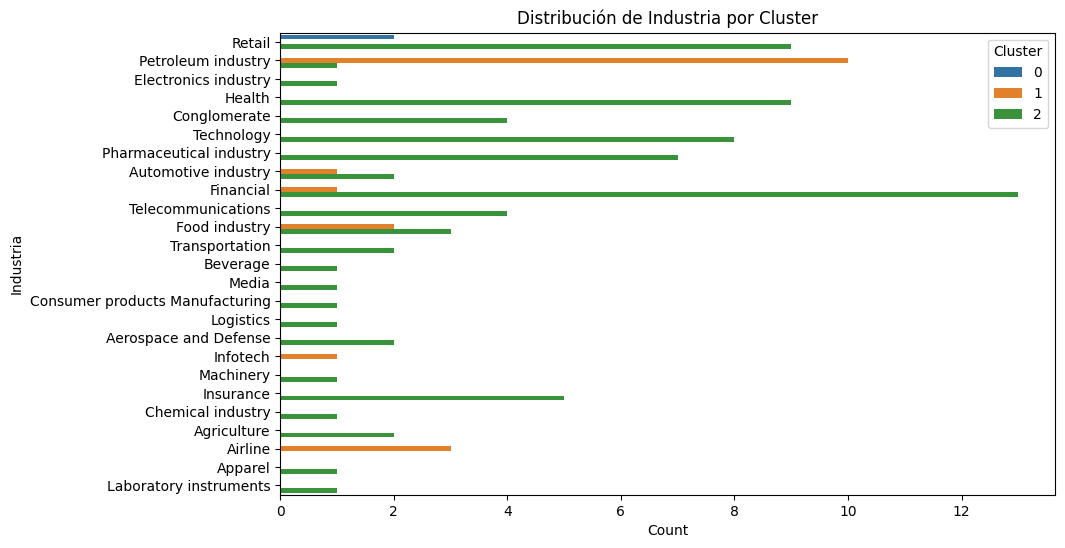

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Industry', hue='Cluster', data=df2)
plt.title('Distribución de Industria por Cluster')
plt.xlabel('Count')
plt.ylabel('Industria')
plt.show()


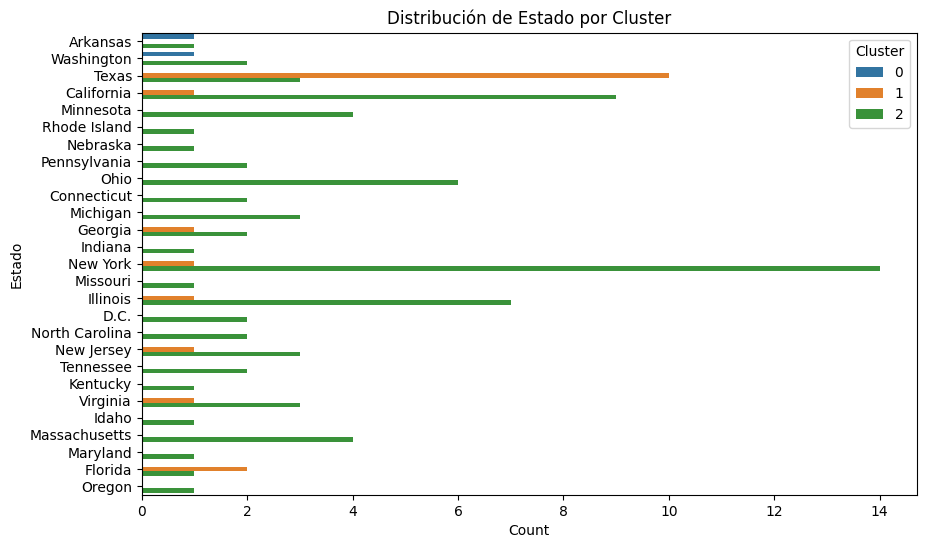

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y='State', hue='Cluster', data=df2)
plt.title('Distribución de Estado por Cluster')
plt.xlabel('Count')
plt.ylabel('Estado')
plt.show()

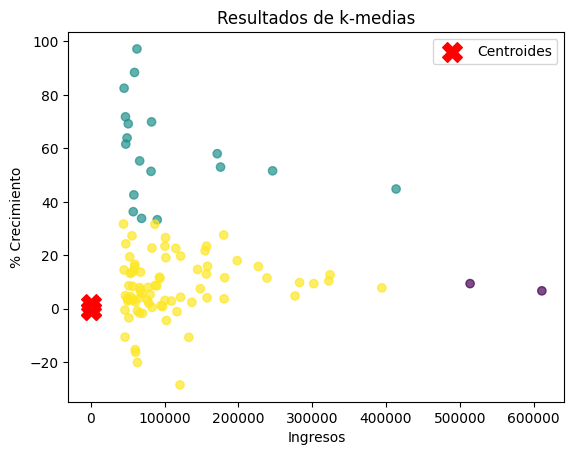

In [ ]:
plt.scatter(df2['Revenue (USD millions)'], df2['Revenue growth'], c=df2['Cluster'], cmap='viridis', alpha=0.7)
plt.scatter(pipeline.named_steps['kmeans'].cluster_centers_[:, 0], pipeline.named_steps['kmeans'].cluster_centers_[:, 1], marker='X', s=200, c='red', label='Centroides')
plt.xlabel('Ingresos')
plt.ylabel('% Crecimiento')
plt.title('Resultados de k-medias')
plt.legend()
plt.show()

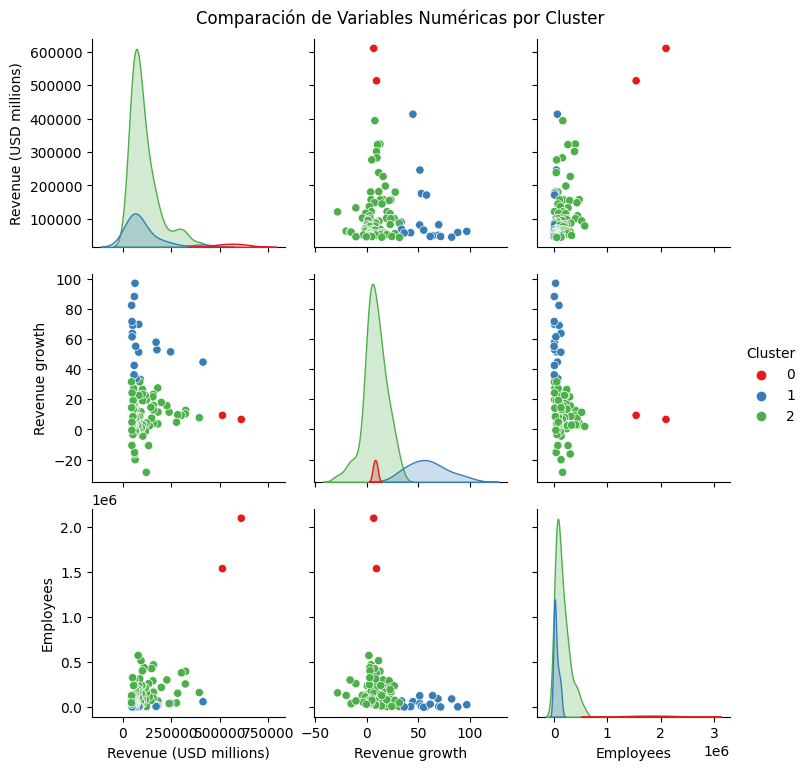

In [ ]:
sns.pairplot(df2, hue='Cluster', palette='Set1')
plt.suptitle('Comparación de Variables Numéricas por Cluster', y=1.02)
plt.show()

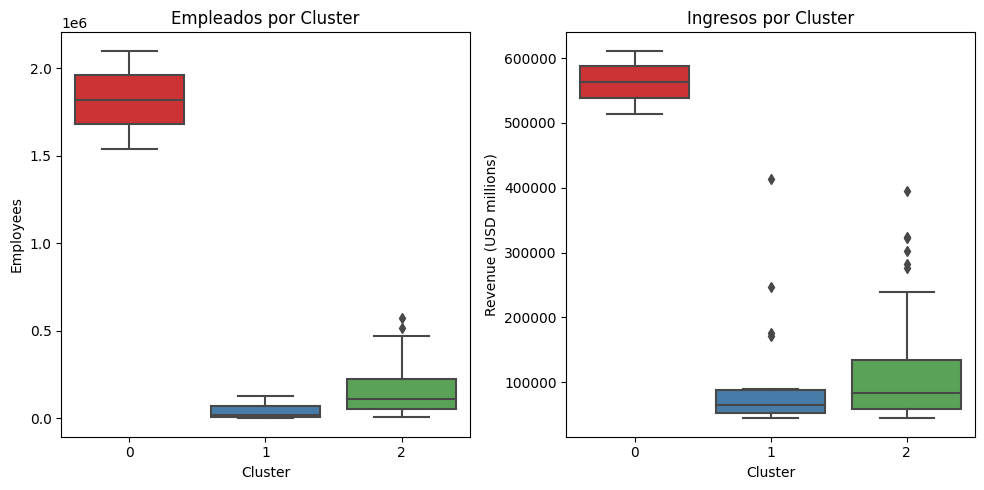

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Employees', data=df2, palette='Set1')
plt.title('Empleados por Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Revenue (USD millions)', data=df2, palette='Set1')
plt.title('Ingresos por Cluster')


plt.tight_layout()
plt.show()

In [ ]:
cluster_0_df = df2[df2['Cluster'] == 0]
cluster_0_df

,Name,Industry,Revenue (USD millions),Revenue growth,Employees,State,Cluster
0,Walmart,Retail,611289,6.7,2100000,Arkansas,0
1,Amazon,Retail,513983,9.4,1540000,Washington,0


Una vez se tiene todo esto ya se pueden analizar los distintos clusters.

El **cluster 0** contiene solo dos empresas que son **Amazon** y **Walmart** las cuales son las dos empresas que más dinero generan y se sitúan en lo más alto del ranking. Las dos se dedican al **retail**, cuentan con **muchísimos** **empleados** y un **crecimiento económico bajo.**

El **cluster 1** está formado mayoritariamente por empresas pertenecientes a la industria del **petróleo**, de la **automoción** y de las **aerolíneas** que se encuentran sobre todo en **Florida** y **Texas**. Tienen un **alto crecimiento** y de media unos 40 000 empleados.

El **cluster 2** tiene la misma media de ingresos que el cluster 1 pero su **crecimiento** es mucho más **bajo** y cuenta con muchos **más** **empleados**. Al ser el cluster más grande es el que más industrias abarca y las que más presencia tienen son la **financiera**, la de la **salud** y el **retail**. Los estados más representados son **Nueva York** y **California**.


Para comprobar la calidad de los grupos creados, se **utiliza** la métrica de la silueta que se utiliza para calcular la bondad de los clusters en función de la cohesión intra-cluster y la separación inter-cluster. Lo que hace es asignar a cada punto de datos un valor que indica qué tan similar es ese punto a su propio grupo en comparación con otros grupos.

In [26]:
silhouette_avg = silhouette_score(transformed_features, df2['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.2357665014288527


La métrica obtenida es de **0.235** que se aproxima a 0 y es bastante **mala**, implicando que muchos datos podrían pertenecer a ese cluster o a otro. Una de las razones es que este algoritmo no funciona muy bien con las variables categóricas por lo que se repite el modelo pero solo con las numéricas.

In [34]:
numeric_features = df2[['Revenue (USD millions)', 'Revenue growth', 'Employees']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features.columns),
    ])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])
pipeline.fit(df2)
transformed_features = pipeline.named_steps['preprocessor'].transform(df2)
silhouette_avg = silhouette_score(transformed_features, df2['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.47352413684545114


Como se puede observar la silueta se duplica llegando a **0.473** que aunque no es un muy buen valor **mejora** al **anterior**. Se realiza el mismo análisis para ver como cambiar los cluster. Resaltar que el que antes era el cluster 0 ahora es el 2, el 1 se mantiene igual y el 2 ahora es el 0.

In [35]:
df2['Cluster'] = pipeline.named_steps['kmeans'].labels_
df2

,Name,Industry,Revenue (USD millions),Revenue growth,Employees,State,Cluster
0,Walmart,Retail,611289,6.7,2100000,Arkansas,1
1,Amazon,Retail,513983,9.4,1540000,Washington,1
2,ExxonMobil,Petroleum industry,413680,44.8,62000,Texas,2
3,Apple,Electronics industry,394328,7.8,164000,California,0
4,UnitedHealth Group,Health,324162,12.7,400000,Minnesota,0
...,...,...,...,...,...,...,...
95,Best Buy,Retail,46298,-10.6,71100,Minnesota,0
96,Bristol-Myers Squibb,Pharmaceutical industry,46159,-0.5,34300,New York,0
97,United Airlines,Airline,44955,82.5,92795,Illinois,2
98,Thermo Fisher Scientific,Laboratory instruments,44915,14.5,130000,Massachusetts,0


In [36]:
resultados = df2.groupby('Cluster').mean().round(2)
print(resultados)

         Revenue (USD millions)  Revenue growth   Employees
Cluster                                                    
0                     110641.29            7.48   158382.23
1                     562636.00            8.05  1820000.00
2                     100067.65           56.40    40459.65


<ipython-input-36-9025c0bf73e6>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resultados = df2.groupby('Cluster').mean().round(2)


In [37]:
conteo_clusters = df2['Cluster'].value_counts()
print(conteo_clusters)

0    78
2    20
1     2
Name: Cluster, dtype: int64


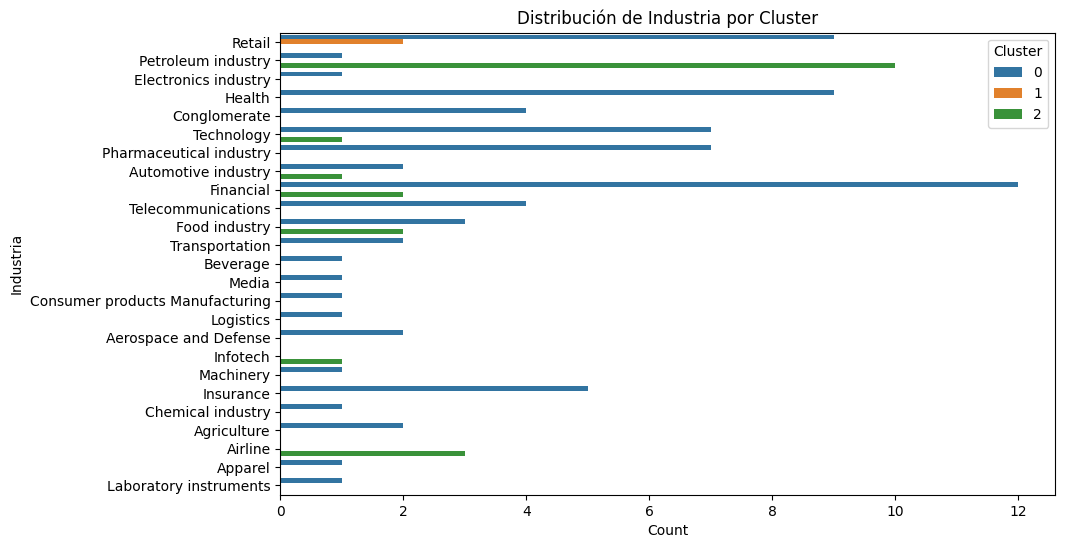

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Industry', hue='Cluster', data=df2)
plt.title('Distribución de Industria por Cluster')
plt.xlabel('Count')
plt.ylabel('Industria')
plt.show()

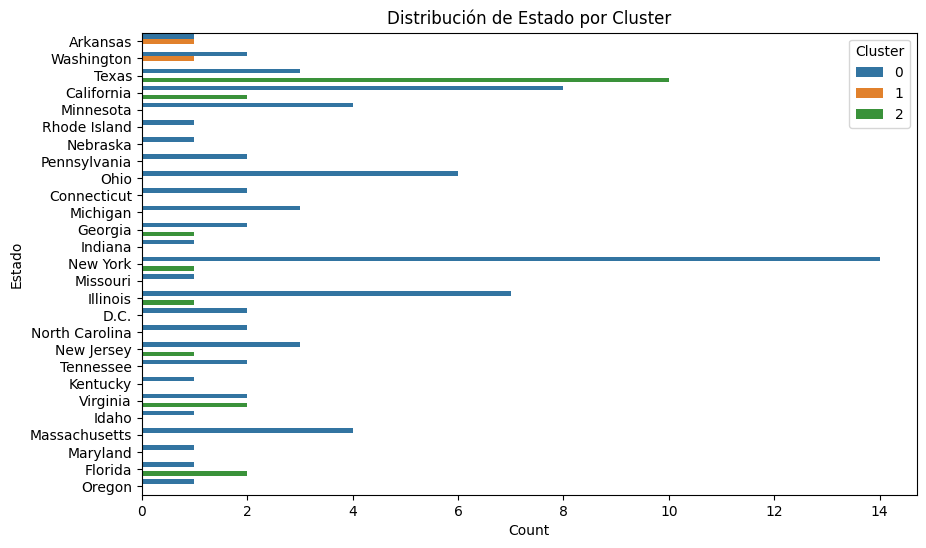

In [39]:
plt.figure(figsize=(10, 6))
sns.countplot(y='State', hue='Cluster', data=df2)
plt.title('Distribución de Estado por Cluster')
plt.xlabel('Count')
plt.ylabel('Estado')
plt.show()

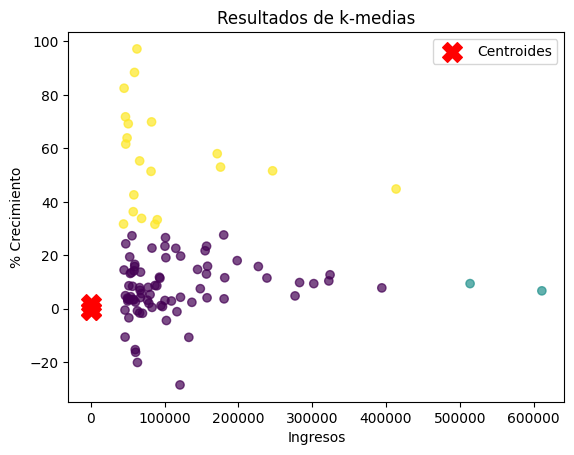

In [40]:
plt.scatter(df2['Revenue (USD millions)'], df2['Revenue growth'], c=df2['Cluster'], cmap='viridis', alpha=0.7)
plt.scatter(pipeline.named_steps['kmeans'].cluster_centers_[:, 0], pipeline.named_steps['kmeans'].cluster_centers_[:, 1], marker='X', s=200, c='red', label='Centroides')
plt.xlabel('Ingresos')
plt.ylabel('% Crecimiento')
plt.title('Resultados de k-medias')
plt.legend()
plt.show()

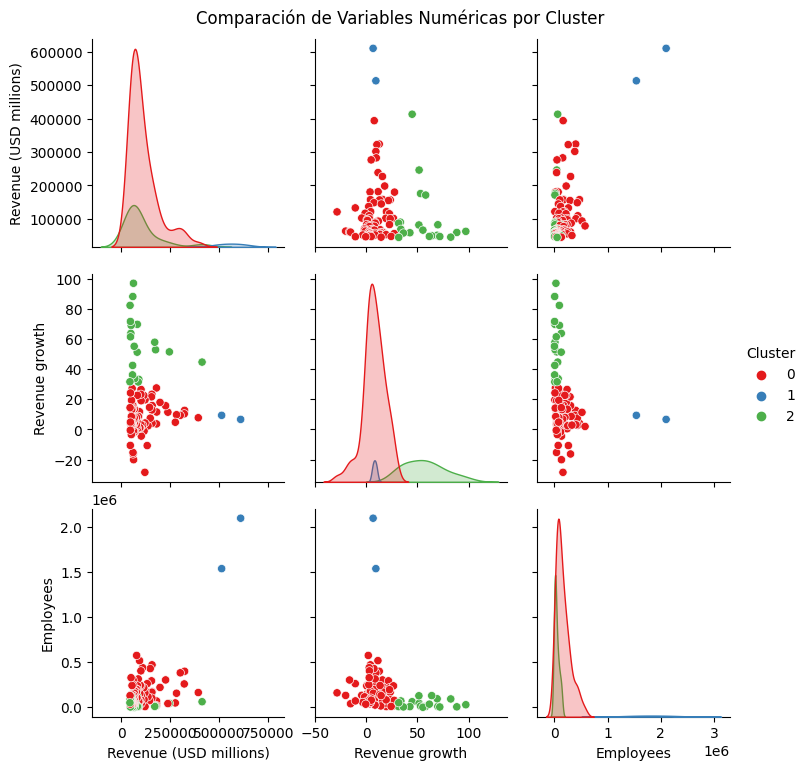

In [41]:
sns.pairplot(df2, hue='Cluster', palette='Set1')
plt.suptitle('Comparación de Variables Numéricas por Cluster', y=1.02)
plt.show()

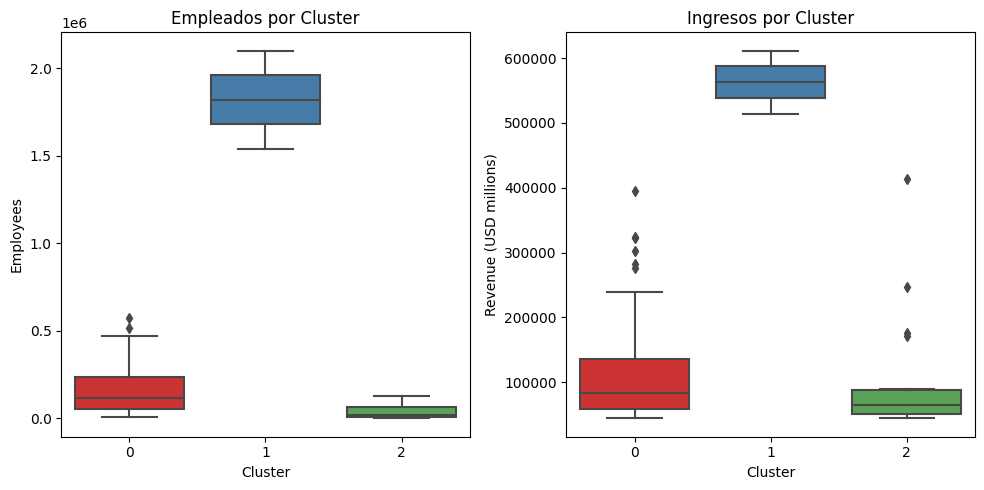

In [42]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Employees', data=df2, palette='Set1')
plt.title('Empleados por Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Revenue (USD millions)', data=df2, palette='Set1')
plt.title('Ingresos por Cluster')


plt.tight_layout()
plt.show()

Se observa que la distribución en los clusters ha cambiado en dos empresas y eso ha hecho que la silueta aumente, pero analizando los datos obtenidos la composición de los clusters es muy similar a la del apartado anterior. Las medias numéricas varían muy poco y las categóricas se manienen igual.

# **Conclusiones**

En este trabajo se ha realizado un ejercicio de **web Scrapping** con el fin de analizar el comportamiento de las 100 empresas con mayores ingresos de Estados Unidos. En un primer lugar se ha hecho un **análisis descriptivo** en el que se ha obtenido información de gran valor sobre como es la composición dentro del ranking, después se han creado **modelos predictivos** para predecir los ingresos en función del resto de variables obteniendo una precisión del 80% y por último se ha creado un **modelo de clustering** para intentar dividir las empresas aunque es resultado no ha sido el esperado.